A quick notebook for comparing the zigzag and hilbert embeddings on CIFAR-10

In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from fastai.basics import *
from timm.loss import SoftTargetCrossEntropy


import sys
sys.path.append('..')

from src.tokenizers.hilbert_embedding import HilbertEmbedding
from src.tokenizers.random_embedding import RandomEmbedding
from src.tokenizers.zigzag_embedding import ZigzagEmbedding
from src.models.vit import VisionTransformer
from src.models.altvit import SimpleViT, HilbertViT
from src.training.scheduler import WarmupCosineScheduler
from src.training.train import train_with_mixup, evaluate

# Set global variables
torch.backends.cudnn.benchmark = True

/home/remco/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/remco/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Initialize the enviroment. Everything here is as closely implemented as the experimental setup in the GFPE-ViT paper

In [2]:
def init_hilbert_model():
    """
    Initialize the Vision Transformer model with Hilbert embedding.

    Returns:
        model (VisionTransformer): The initialized Vision Transformer model with Hilbert embedding.
        optimizer (torch.optim.Optimizer): AdamW optimizer for training the model.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Cosine Annealing LR scheduler for learning rate adjustment.
    """
    patch_embed = HilbertEmbedding(
        img_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=512,
        num_classes=10
    ).to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.00005,
        betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=10,
        eta_min=0.0001
    )

    return model, optimizer, scheduler


def init_zigzag_model():
    """
    Initialize the Vision Transformer model with Zigzag embedding.

    Returns:
        model (VisionTransformer): The initialized Vision Transformer model with Zigzag embedding.
        optimizer (torch.optim.Optimizer): AdamW optimizer for training the model.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Cosine Annealing LR scheduler for learning rate adjustment.
    """
    patch_embed = ZigzagEmbedding(
        img_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=512,
        num_classes=10
    ).to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.00005,
        betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=10,
        eta_min=0.0001
    )

    return model, optimizer, scheduler


# Define the device to be used for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std deviation
])

# Define the training loss criterion (Soft Target Cross Entropy for mixup)
train_criterion = SoftTargetCrossEntropy()

# Define the testing loss criterion (Standard Cross Entropy Loss)
test_criterion = nn.CrossEntropyLoss()


Now we're going to load in the dataset and model. For now we've implemented CIFAR-10

In [3]:
def load_data(dataset_name):
    """Load and return PyTorch-ready datasets."""
    if dataset_name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        return train_set, test_set

    elif dataset_name == 'imagenette':
        path = untar_data(URLs.IMAGENETTE_320)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
        ])

        transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            normalize
        ])

        train_dataset = datasets.ImageFolder(os.path.join(path, 'train'), transform=transform_train)
        val_dataset = datasets.ImageFolder(os.path.join(path, 'val'), transform=transform_val)

        return train_dataset, val_dataset

    else:
        raise ValueError(f"Dataset '{dataset_name}' not supported.")

train_set, test_set = load_data('imagenette')
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7731092..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64

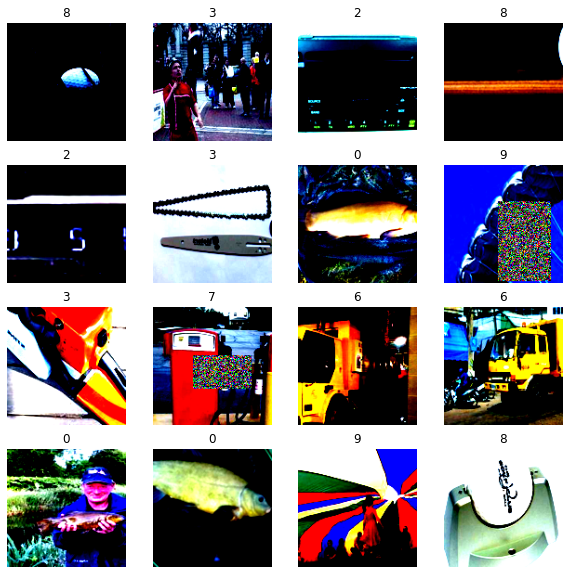

In [4]:
# Show 16 random images from the training set
def show_images(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].permute(1, 2, 0).numpy())
        ax.set_title(labels[i].item())
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(train_loader))
# Show the images
show_images(images, labels)

Now we're going to train the hilbert model and the zigzag model each for 10 epochs five times on the CIFAR-10 dataset.
We will save the model weights and the training history for each run.

In [5]:
iterations = 3
epochs = 10
total_steps = epochs * len(train_loader)

def train_and_evaluate_model(iterations, epochs, init_function=None):
    train_accuracies = []
    test_accuracies = []
    for iter in range(iterations):
        model, optimizer, scheduler = init_function()
        model.to(device)
        iter_train_acc = []
        iter_test_acc = []
        for epoch in range(epochs):
            train_loss, train_acc = train_with_mixup(
                model, train_loader, train_criterion, optimizer, scheduler, device
            )
            test_loss, test_acc = evaluate(model, test_loader, test_criterion, device)

            iter_train_acc.append(train_acc)
            iter_test_acc.append(test_acc)

            print(
                f"Iteration {iter+1}, Epoch {epoch+1}: "
                f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
                f"Test Loss={test_loss:.4f}, Acc={test_acc:.4f}"
            )
        train_accuracies.append(iter_train_acc)
        test_accuracies.append(iter_test_acc)
    return train_accuracies, test_accuracies

train_accuracies_zigzag, test_accuracies_zigzag = train_and_evaluate_model(
    iterations, epochs, init_zigzag_model)
train_accuracies_hilbert, test_accuracies_hilbert = train_and_evaluate_model(
    iterations, epochs, init_hilbert_model)

Training:   1%|          | 2/296 [00:00<00:20, 14.41it/s]    

Iteration 1, Epoch 1: Train Loss=2.0937, Acc=0.2479, Test Loss=1.9362, Acc=0.3256


Training:   1%|          | 2/296 [00:00<00:20, 14.23it/s]    

Iteration 1, Epoch 2: Train Loss=1.9091, Acc=0.3448, Test Loss=1.7180, Acc=0.4224


Training:   1%|          | 2/296 [00:00<00:19, 15.39it/s]    

Iteration 1, Epoch 3: Train Loss=1.8095, Acc=0.3832, Test Loss=1.6110, Acc=0.4632


Training:   1%|          | 2/296 [00:00<00:19, 15.29it/s]    

Iteration 1, Epoch 4: Train Loss=1.7278, Acc=0.4202, Test Loss=1.5488, Acc=0.4871


Training:   1%|          | 2/296 [00:00<00:20, 14.63it/s]    

Iteration 1, Epoch 5: Train Loss=1.6698, Acc=0.4461, Test Loss=1.4646, Acc=0.5190


Training:   1%|          | 2/296 [00:00<00:19, 15.08it/s]    

Iteration 1, Epoch 6: Train Loss=1.6353, Acc=0.4542, Test Loss=1.4508, Acc=0.5276


Training:   1%|          | 2/296 [00:00<00:19, 15.10it/s]    

Iteration 1, Epoch 7: Train Loss=1.6046, Acc=0.4683, Test Loss=1.4306, Acc=0.5320


Training:   1%|          | 2/296 [00:00<00:19, 14.72it/s]    

Iteration 1, Epoch 8: Train Loss=1.5722, Acc=0.4799, Test Loss=1.3983, Acc=0.5404


Training:   1%|          | 2/296 [00:00<00:19, 15.14it/s]    

Iteration 1, Epoch 9: Train Loss=1.5400, Acc=0.4940, Test Loss=1.3421, Acc=0.5646


Training:   1%|          | 2/296 [00:00<00:19, 15.05it/s]    

Iteration 1, Epoch 10: Train Loss=1.5412, Acc=0.4930, Test Loss=1.3209, Acc=0.5791


Training:   1%|          | 2/296 [00:00<00:20, 14.59it/s]    

Iteration 2, Epoch 1: Train Loss=2.1000, Acc=0.2456, Test Loss=1.9361, Acc=0.3238


Training:   1%|          | 2/296 [00:00<00:19, 15.15it/s]    

Iteration 2, Epoch 2: Train Loss=1.9148, Acc=0.3394, Test Loss=1.7537, Acc=0.4206


Training:   1%|          | 2/296 [00:00<00:19, 15.06it/s]    

Iteration 2, Epoch 3: Train Loss=1.8297, Acc=0.3752, Test Loss=1.6160, Acc=0.4703


Training:   1%|          | 2/296 [00:00<00:19, 14.98it/s]    

Iteration 2, Epoch 4: Train Loss=1.7540, Acc=0.4081, Test Loss=1.5620, Acc=0.4841


Training:   1%|          | 2/296 [00:00<00:19, 14.84it/s]    

Iteration 2, Epoch 5: Train Loss=1.6808, Acc=0.4354, Test Loss=1.4700, Acc=0.5078


Training:   1%|          | 2/296 [00:00<00:19, 15.07it/s]    

Iteration 2, Epoch 6: Train Loss=1.6308, Acc=0.4606, Test Loss=1.4479, Acc=0.5210


Training:   1%|          | 2/296 [00:00<00:20, 14.52it/s]    

Iteration 2, Epoch 7: Train Loss=1.5980, Acc=0.4728, Test Loss=1.4011, Acc=0.5376


Training:   1%|          | 2/296 [00:00<00:18, 15.59it/s]    

Iteration 2, Epoch 8: Train Loss=1.5437, Acc=0.4894, Test Loss=1.3572, Acc=0.5592


Training:   1%|          | 2/296 [00:00<00:19, 14.94it/s]    

Iteration 2, Epoch 9: Train Loss=1.5333, Acc=0.4967, Test Loss=1.3319, Acc=0.5628


Training:   1%|          | 2/296 [00:00<00:20, 14.68it/s]    

Iteration 2, Epoch 10: Train Loss=1.5103, Acc=0.5075, Test Loss=1.2901, Acc=0.5725


Training:   1%|          | 2/296 [00:00<00:20, 14.63it/s]    

Iteration 3, Epoch 1: Train Loss=2.0982, Acc=0.2485, Test Loss=1.9211, Acc=0.3437


Training:   1%|          | 2/296 [00:00<00:19, 15.19it/s]    

Iteration 3, Epoch 2: Train Loss=1.9072, Acc=0.3417, Test Loss=1.7034, Acc=0.4196


Training:   1%|          | 2/296 [00:00<00:19, 15.01it/s]    

Iteration 3, Epoch 3: Train Loss=1.7980, Acc=0.3833, Test Loss=1.5957, Acc=0.4670


Training:   1%|          | 2/296 [00:00<00:19, 15.02it/s]    

Iteration 3, Epoch 4: Train Loss=1.7301, Acc=0.4121, Test Loss=1.5134, Acc=0.5055


Training:   1%|          | 2/296 [00:00<00:19, 15.31it/s]    

Iteration 3, Epoch 5: Train Loss=1.6776, Acc=0.4386, Test Loss=1.4496, Acc=0.5312


Training:   1%|          | 2/296 [00:00<00:22, 12.81it/s]    

Iteration 3, Epoch 6: Train Loss=1.6191, Acc=0.4622, Test Loss=1.3931, Acc=0.5432


Training:   1%|          | 2/296 [00:00<00:20, 14.69it/s]    

Iteration 3, Epoch 7: Train Loss=1.5874, Acc=0.4681, Test Loss=1.3571, Acc=0.5569


Training:   1%|          | 2/296 [00:00<00:19, 15.19it/s]    

Iteration 3, Epoch 8: Train Loss=1.5880, Acc=0.4817, Test Loss=1.3714, Acc=0.5516


Training:   1%|          | 2/296 [00:00<00:21, 13.79it/s]    

Iteration 3, Epoch 9: Train Loss=1.5307, Acc=0.4984, Test Loss=1.3236, Acc=0.5687


Training:   0%|          | 1/296 [00:00<00:48,  6.14it/s]    

Iteration 3, Epoch 10: Train Loss=1.5480, Acc=0.4934, Test Loss=1.3258, Acc=0.5587


Training:   1%|          | 2/296 [00:00<00:20, 14.67it/s]    

Iteration 1, Epoch 1: Train Loss=2.1185, Acc=0.2441, Test Loss=2.0032, Acc=0.3032


Training:   1%|          | 2/296 [00:00<00:22, 13.07it/s]    

Iteration 1, Epoch 2: Train Loss=1.9747, Acc=0.3076, Test Loss=1.9126, Acc=0.3429


Training:   1%|          | 2/296 [00:00<00:20, 14.05it/s]    

Iteration 1, Epoch 3: Train Loss=1.8772, Acc=0.3568, Test Loss=1.6914, Acc=0.4341


Training:   1%|          | 2/296 [00:00<00:20, 14.35it/s]    

Iteration 1, Epoch 4: Train Loss=1.7897, Acc=0.3945, Test Loss=1.6896, Acc=0.4161


Training:   1%|          | 2/296 [00:00<00:19, 14.88it/s]    

Iteration 1, Epoch 5: Train Loss=1.7441, Acc=0.4127, Test Loss=1.5608, Acc=0.4841


Training:   1%|          | 2/296 [00:00<00:19, 14.92it/s]    

Iteration 1, Epoch 6: Train Loss=1.7090, Acc=0.4310, Test Loss=1.5543, Acc=0.4892


Training:   1%|          | 2/296 [00:00<00:19, 14.88it/s]    

Iteration 1, Epoch 7: Train Loss=1.6615, Acc=0.4455, Test Loss=1.4975, Acc=0.4973


Training:   1%|          | 2/296 [00:00<00:20, 14.68it/s]    

Iteration 1, Epoch 8: Train Loss=1.6058, Acc=0.4608, Test Loss=1.4603, Acc=0.5108


Training:   1%|          | 2/296 [00:00<00:20, 14.62it/s]    

Iteration 1, Epoch 9: Train Loss=1.6095, Acc=0.4636, Test Loss=1.4562, Acc=0.5106


Training:   1%|          | 2/296 [00:00<00:19, 14.76it/s]    

Iteration 1, Epoch 10: Train Loss=1.5880, Acc=0.4733, Test Loss=1.3975, Acc=0.5383


Training:   1%|          | 2/296 [00:00<00:19, 15.04it/s]    

Iteration 2, Epoch 1: Train Loss=2.1187, Acc=0.2397, Test Loss=1.9679, Acc=0.3090


Training:   1%|          | 2/296 [00:00<00:18, 16.04it/s]    

Iteration 2, Epoch 2: Train Loss=1.9833, Acc=0.3059, Test Loss=1.8715, Acc=0.3549


Training:   1%|          | 2/296 [00:00<00:19, 15.12it/s]    

Iteration 2, Epoch 3: Train Loss=1.9093, Acc=0.3388, Test Loss=1.7220, Acc=0.4171


Training:   1%|          | 2/296 [00:00<00:19, 15.04it/s]    

Iteration 2, Epoch 4: Train Loss=1.8237, Acc=0.3791, Test Loss=1.6433, Acc=0.4589


Training:   1%|          | 2/296 [00:00<00:19, 15.00it/s]    

Iteration 2, Epoch 5: Train Loss=1.7795, Acc=0.3956, Test Loss=1.5810, Acc=0.4744


Training:   1%|          | 2/296 [00:00<00:20, 14.37it/s]    

Iteration 2, Epoch 6: Train Loss=1.7059, Acc=0.4227, Test Loss=1.5334, Acc=0.4825


Training:   1%|          | 2/296 [00:00<00:19, 14.83it/s]    

Iteration 2, Epoch 7: Train Loss=1.7000, Acc=0.4303, Test Loss=1.5338, Acc=0.4899


Training:   1%|          | 2/296 [00:00<00:20, 14.54it/s]    

Iteration 2, Epoch 8: Train Loss=1.6605, Acc=0.4490, Test Loss=1.4669, Acc=0.5113


Training:   1%|          | 2/296 [00:00<00:19, 15.09it/s]    

Iteration 2, Epoch 9: Train Loss=1.6229, Acc=0.4542, Test Loss=1.4232, Acc=0.5302


Training:   1%|          | 2/296 [00:00<00:19, 14.71it/s]    

Iteration 2, Epoch 10: Train Loss=1.5994, Acc=0.4679, Test Loss=1.3911, Acc=0.5366


Training:   1%|          | 2/296 [00:00<00:19, 14.75it/s]    

Iteration 3, Epoch 1: Train Loss=2.1110, Acc=0.2396, Test Loss=1.9776, Acc=0.3057


Training:   1%|          | 2/296 [00:00<00:20, 14.40it/s]    

Iteration 3, Epoch 2: Train Loss=1.9675, Acc=0.3103, Test Loss=1.8208, Acc=0.3755


Training:   1%|          | 2/296 [00:00<00:20, 14.64it/s]    

Iteration 3, Epoch 3: Train Loss=1.8775, Acc=0.3541, Test Loss=1.7110, Acc=0.4158


Training:   1%|          | 2/296 [00:00<00:19, 14.73it/s]    

Iteration 3, Epoch 4: Train Loss=1.7973, Acc=0.3892, Test Loss=1.6309, Acc=0.4464


Training:   1%|          | 2/296 [00:00<00:21, 13.89it/s]    

Iteration 3, Epoch 5: Train Loss=1.7951, Acc=0.3891, Test Loss=1.6234, Acc=0.4660


Training:   1%|          | 2/296 [00:00<00:20, 14.09it/s]    

Iteration 3, Epoch 6: Train Loss=1.7144, Acc=0.4206, Test Loss=1.5473, Acc=0.4810


Training:   1%|          | 2/296 [00:00<00:20, 14.49it/s]    

Iteration 3, Epoch 7: Train Loss=1.6821, Acc=0.4385, Test Loss=1.5245, Acc=0.4846


Training:   1%|          | 2/296 [00:00<00:20, 14.56it/s]    

Iteration 3, Epoch 8: Train Loss=1.6505, Acc=0.4437, Test Loss=1.4608, Acc=0.5144


Training:   1%|          | 2/296 [00:00<00:19, 15.32it/s]    

Iteration 3, Epoch 9: Train Loss=1.6527, Acc=0.4479, Test Loss=1.4292, Acc=0.5256


Iteration 3, Epoch 10: Train Loss=1.5897, Acc=0.4760, Test Loss=1.4128, Acc=0.5259


Now we're going to visualize the training history of the hilbert and zigzag models.

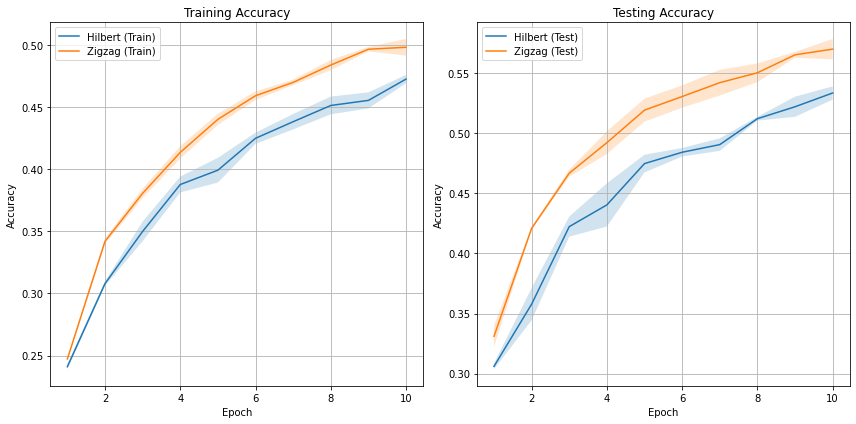

In [6]:
# Convert to numpy arrays
train_hilbert = np.array(train_accuracies_hilbert)
test_hilbert = np.array(test_accuracies_hilbert)
train_zigzag = np.array(train_accuracies_zigzag)
test_zigzag = np.array(test_accuracies_zigzag)

# Compute mean and std deviation
def compute_stats(data):
    return data.mean(axis=0), data.std(axis=0)

train_h_mean, train_h_std = compute_stats(train_hilbert)
test_h_mean, test_h_std = compute_stats(test_hilbert)
train_z_mean, train_z_std = compute_stats(train_zigzag)
test_z_mean, test_z_std = compute_stats(test_zigzag)

# Plotting
epochs_range = np.arange(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_h_mean, label="Hilbert (Train)")
plt.fill_between(epochs_range, train_h_mean - train_h_std, train_h_mean + train_h_std, alpha=0.2)
plt.plot(epochs_range, train_z_mean, label="Zigzag (Train)")
plt.fill_between(epochs_range, train_z_mean - train_z_std, train_z_mean + train_z_std, alpha=0.2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_h_mean, label="Hilbert (Test)")
plt.fill_between(epochs_range, test_h_mean - test_h_std, test_h_mean + test_h_std, alpha=0.2)
plt.plot(epochs_range, test_z_mean, label="Zigzag (Test)")
plt.fill_between(epochs_range, test_z_mean - test_z_std, test_z_mean + test_z_std, alpha=0.2)
plt.title("Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()